# Import Libraries


In [1]:
!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 286.4 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.1 MB/s eta 0:00:00


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv, GATConv, SAGEConv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Dataset Description

Put flight_routes.csv and airports.txt into your Drive (main folder) for the following graph setup to execute correctly.

# Graph Setup
The graph represents airports as nodes, with flights as edges between them. Node attributes include geolocation and airport metadata, while edge attributes capture flight-specific data such as distance, number of passengers, and fares.

In [2]:
import csv
import os
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

class GraphSetup:
    def __init__(self, data_path):
        """
        Initializes the graph setup with flight data and airport geolocation data.

        Args:
            data_path (str): Path to the flight routes CSV file.
        """
        # Supplemental dataset containing airport geolocations
        geotags_path = '/content/drive/MyDrive/airports.txt'
        sup_df = pd.read_csv(geotags_path, header=None, names=[
            "CustomID", "Name", "City", "Country", "IATA", "ICAO",
            "Latitude", "Longitude", "Altitude", "Timezone",
            "DST", "Tz DB time zone", "IsAirport", "Src"
        ])
        geotags = {}
        for _, airport in sup_df.iterrows():
            if pd.notna(airport['IATA']) and pd.notna(airport['Latitude']) and pd.notna(airport['Longitude']):
                geotags[airport['IATA']] = (airport['Latitude'], airport['Longitude'])

        # Main dataset
        df = pd.read_csv(data_path, low_memory=False)

        # Drop irrelevant columns
        df_filtered = df.drop(df.columns[[0, 3, 4, 20, 21]], axis=1)

        # Extract airport IDs
        airport1 = df_filtered.iloc[:, 4].unique()
        airport2 = df_filtered.iloc[:, 5].unique()
        self.nodes = list(set(airport1) | set(airport2))

        # Initialize attributes for airports
        airport_attributes = {}
        for _, row in df_filtered.iterrows():
            airport1id = row['airportid_1']
            airport2id = row['airportid_2']
            airport1 = row['airport_1']
            airport2 = row['airport_2']
            city1 = row['city1']
            city2 = row['city2']
            latitude1, longitude1 = geotags.get(airport1, (None, None))
            latitude2, longitude2 = geotags.get(airport2, (None, None))

            if airport1id not in airport_attributes:
                airport_attributes[airport1id] = {'airport': airport1, 'city': city1, 'latitude': latitude1, 'longitude': longitude1}

            if airport2id not in airport_attributes:
                airport_attributes[airport2id] = {'airport': airport2, 'city': city2, 'latitude': latitude2, 'longitude': longitude2}

        # Create a directed graph and add nodes with attributes
        self.graph = nx.DiGraph()
        self.graph.add_nodes_from(airport_attributes.keys())
        nx.set_node_attributes(self.graph, airport_attributes)

        # Split the dataset into training and testing sets
        self.train_set, self.test_set = train_test_split(df_filtered, test_size=0.2)

    def train(self):
        """Load edges into the directed graph and set edge attributes."""
        self.edge_labels = {}

        for _, row in self.train_set.iterrows():
            airport1id = row['airportid_1']
            airport2id = row['airportid_2']
            year = row['Year']
            quarter = row['quarter']
            miles = row['nsmiles']
            passengers = row['passengers']
            carrier_lg = row['carrier_lg']
            large_ms = row['large_ms']
            fare_lg = row['fare_lg']
            carrier_low = row['carrier_low']
            lf_ms = row['lf_ms']
            fare_low = row['fare_low']
            label = row['tbl1apk']

            # Add directed edge with attributes
            self.graph.add_edge(
                airport1id,
                airport2id,
                year=year,
                quarter=quarter,
                miles=miles,
                passengers=passengers,
                carrier_lg=carrier_lg,
                large_ms=large_ms,
                fare_lg=fare_lg,
                carrier_low=carrier_low,
                lf_ms=lf_ms,
                fare_low=fare_low,
                label=label
            )

            self.edge_labels[(airport1id, airport2id, label)] = fare_lg

    def evaluate(self, test_set):
        """Placeholder for evaluation logic."""
        pass

    def visualize_graph(self, num_nodes=50):
        """Visualize a subset of the directed graph."""
        plt.figure(figsize=(12, 8))

        subgraph = self.graph.subgraph(list(self.graph.nodes)[:num_nodes])
        pos = nx.spring_layout(subgraph)

        nx.draw(subgraph, pos, with_labels=True, node_size=500, node_color="lightblue", font_size=8, arrows=True)
        nx.draw_networkx_edge_labels(
            subgraph, pos,
            edge_labels={(u, v): d['miles'] for u, v, d in subgraph.edges(data=True)},
            font_size=7, label_pos=0.5
        )

        plt.title("Visualization of Directed Airport Graph")
        plt.show()

Mounted at /content/drive


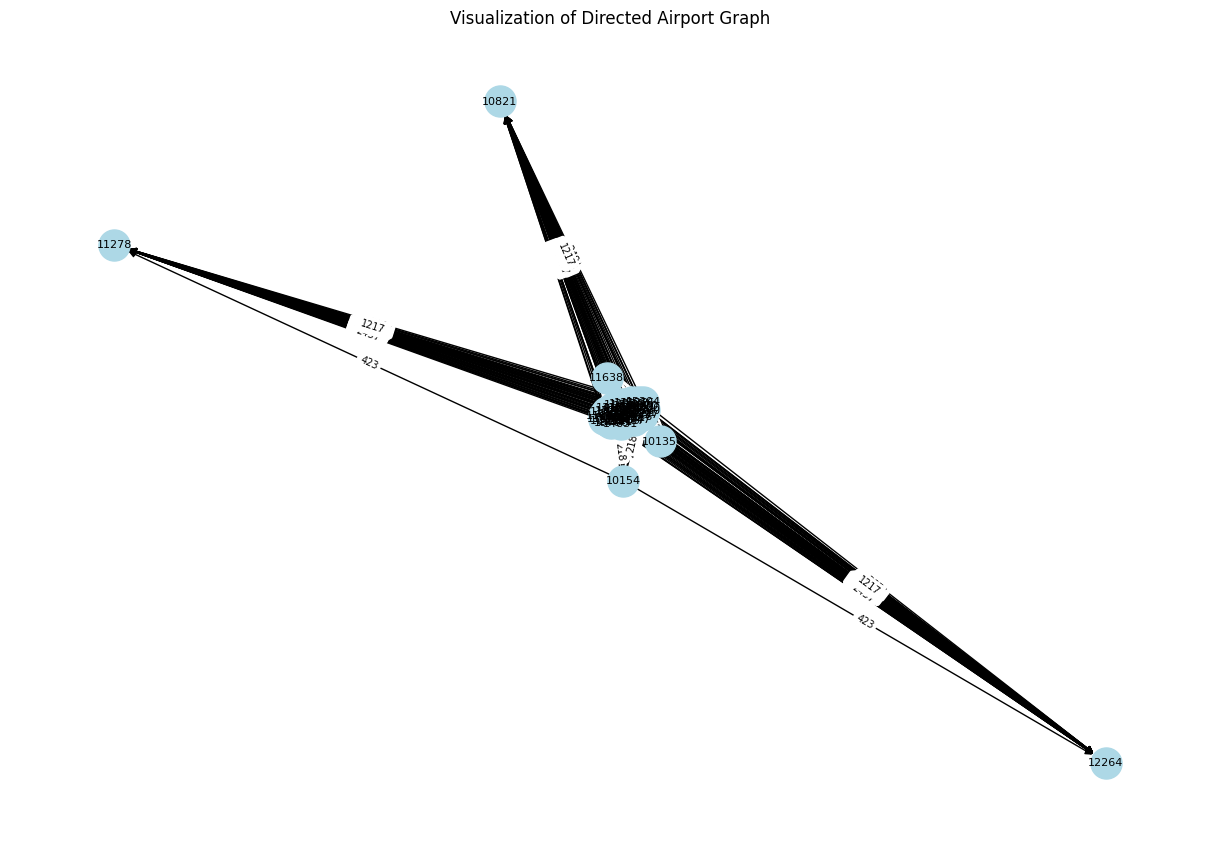

In [3]:
from google.colab import drive
drive.mount('/content/drive')

data_path = '/content/drive/MyDrive/flight_routes.csv'

g = GraphSetup(data_path)
g.train()
g.visualize_graph(num_nodes=50)

# Baseline GNN

# Graph Preprocessing - Edge-to-Node Feature Movement for Temporal Snapshots


In [5]:
class EdgeToNodeAttention(nn.Module):
    def __init__(self, node_feature_dim, edge_feature_dim, hidden_dim):
        super(EdgeToNodeAttention, self).__init__()

        input_dim = edge_feature_dim + edge_feature_dim  # Combined dimensions for attention
        self.attention = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, 1)
        )

        # Transform node features to match edge feature dimensions
        self.node_transform = nn.Linear(node_feature_dim, edge_feature_dim)

        # TODO: increase feature dimension size / play with how the attention mechanism weights
        # Transform weighted edge features back to node feature dimensions
        self.edge_to_node_transform = nn.Linear(edge_feature_dim, node_feature_dim)

    def forward(self, g, node_features, edge_features):
        updated_node_features = {node: torch.zeros_like(torch.tensor(node_features[node], dtype=torch.float32))
                                 for node in g.nodes()}  # Initialize updated features

        for u, v, data in g.edges(data=True):
            # Extract node and edge features
            node_v = torch.tensor(node_features[v], dtype=torch.float32)  # Target node feature vector
            edge_uv = torch.tensor(edge_features[(u, v)], dtype=torch.float32)  # Edge feature vector

            # Transform node_v to match edge_uv dimensions
            transformed_node_v = self.node_transform(node_v)

            # Concatenate transformed node features and edge features
            combined = torch.cat([transformed_node_v, edge_uv], dim=-1)

            # Attention scoring
            score = self.attention(combined)

            # Normalize attention scores
            normalized_weight = F.softmax(score - score.max(), dim=0)

            # Reshape and expand normalized weights to match edge_uv dimensions
            normalized_weight = normalized_weight.view(-1).expand_as(edge_uv)

            # Apply attention weights to edge features
            weighted_edge_feature = normalized_weight * edge_uv

            # Transform weighted edge features back to node feature dimensions
            weighted_edge_feature_transformed = self.edge_to_node_transform(weighted_edge_feature)

            # Aggregate weighted features into the target node
            updated_node_features[v] += weighted_edge_feature_transformed

        # Convert updated features to a standard dictionary format
        updated_node_features = {node: updated_node_features[node].tolist() for node in updated_node_features}
        return updated_node_features


NameError: name 'nn' is not defined

In [ ]:
import networkx as nx

def generate_snapshots(graph, node_features, edge_features, start_year, start_quarter, end_year, end_quarter, edge_to_node_attention):
    snapshots = []

    current_year, current_quarter = start_year, start_quarter

    while (current_year < end_year) or (current_year == end_year and current_quarter <= end_quarter):
        print(f"Processing snapshot for Year: {current_year}, Quarter: {current_quarter}")

        # Filter edges for the current year and quarter
        filtered_edges = [
            (u, v, data) for u, v, data in graph.edges(data=True)
            if data.get("year") == current_year and data.get("quarter") == current_quarter
        ]
        print(f"Filtered Edges: {len(filtered_edges)}")  # Debugging

        # Skip if no edges exist for this time step
        if not filtered_edges:
            print(f"No edges found for Year: {current_year}, Quarter: {current_quarter}. Skipping.")
            # Increment quarter
            if current_quarter == 4:
                current_quarter = 1
                current_year += 1
            else:
                current_quarter += 1
            continue

        # Create a subgraph for the snapshot
        snapshot_graph = nx.DiGraph()
        snapshot_graph.add_nodes_from(graph.nodes(data=True))
        snapshot_graph.add_edges_from(filtered_edges)

        # Update edge features using the attention mechanism
        edge_features_snapshot = {
            (u, v): edge_features[(u, v)]
            for u, v, data in filtered_edges
        }
        # Perform edge-to-node attention to compute updated node features
        updated_node_features = edge_to_node_attention(snapshot_graph, node_features, edge_features_snapshot)

        # Store updated node features back in the snapshot graph
        for node, feature in updated_node_features.items():
            snapshot_graph.nodes[node]["updated_features"] = feature

        # Add the snapshot to the list
        snapshots.append(snapshot_graph)

        # Increment quarter
        if current_quarter == 4:
            current_quarter = 1
            current_year += 1
        else:
            current_quarter += 1

    return snapshots

edge_to_node_attention = EdgeToNodeAttention(node_feature_dim=2, edge_feature_dim=8, hidden_dim=8)

node_features = {
    node: [
        data.get('latitude', 0.0) if data.get('latitude') is not None else 0.0,  # Latitude
        data.get('longitude', 0.0) if data.get('longitude') is not None else 0.0  # Longitude
    ]
    for node, data in g.graph.nodes(data=True)
}

# TODO: do numerical carrier mappings and include those
edge_features = {
    (u, v): [
        data.get('miles', 0.0) if data.get('miles') is not None else 0.0,
        data.get('year', 0.0) if data.get('year') is not None else 0.0, # year
        data.get('quarter', 0.0) if data.get('quarter') is not None else 0.0,
        data.get('passengers', 0.0) if data.get('passengers') is not None else 0.0,  # Passengers
        data.get('large_ms', 0.0) if data.get('large_ms') is not None else 0.0,      # Large market share
        data.get('fare_lg', 0.0) if data.get('fare_lg') is not None else 0.0,        # Fare for large market
        data.get('lf_ms', 0.0) if data.get('lf_ms') is not None else 0.0,            # Load factor market share
        data.get('fare_low', 0.0) if data.get('fare_low') is not None else 0.0       # Fare for low market
    ]
    for u, v, data in g.graph.edges(data=True)
}

snapshots = generate_snapshots(
    g.graph,            # Original graph
    node_features,      # Node features
    edge_features,      # Edge features
    start_year=1993,    # Start year
    start_quarter=1,    # Start quarter
    end_year=2024,      # End year
    end_quarter=1,      # End quarter
    edge_to_node_attention=edge_to_node_attention  # Attention mechanism
)

# Example: Print the number of snapshots generated
print(f"Total snapshots generated: {len(snapshots)}")


Processing snapshot for Year: 1993, Quarter: 1
Filtered Edges: 85
Processing snapshot for Year: 1993, Quarter: 2
Filtered Edges: 112
Processing snapshot for Year: 1993, Quarter: 3
Filtered Edges: 91
Processing snapshot for Year: 1993, Quarter: 4
Filtered Edges: 99
Processing snapshot for Year: 1994, Quarter: 1
Filtered Edges: 137
Processing snapshot for Year: 1994, Quarter: 2
Filtered Edges: 0
No edges found for Year: 1994, Quarter: 2. Skipping.
Processing snapshot for Year: 1994, Quarter: 3
Filtered Edges: 0
No edges found for Year: 1994, Quarter: 3. Skipping.
Processing snapshot for Year: 1994, Quarter: 4
Filtered Edges: 0
No edges found for Year: 1994, Quarter: 4. Skipping.
Processing snapshot for Year: 1995, Quarter: 1
Filtered Edges: 0
No edges found for Year: 1995, Quarter: 1. Skipping.
Processing snapshot for Year: 1995, Quarter: 2
Filtered Edges: 0
No edges found for Year: 1995, Quarter: 2. Skipping.
Processing snapshot for Year: 1995, Quarter: 3
Filtered Edges: 0
No edges foun

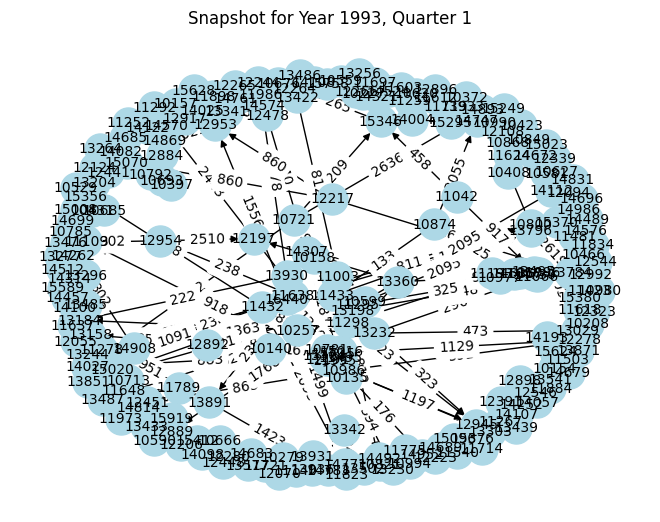


Node Features:
Node 10135: {'airport': 'ABE', 'city': 'Allentown/Bethlehem/Easton, PA', 'latitude': 40.652099609375, 'longitude': -75.44080352783203, 'updated_features': [0.0, 0.0]}
Node 14112: {'airport': 'PIE', 'city': 'Tampa, FL (Metropolitan Area)', 'latitude': 27.91020012, 'longitude': -82.68740082, 'updated_features': [0.0, 0.0]}
Node 15304: {'airport': 'TPA', 'city': 'Tampa, FL (Metropolitan Area)', 'latitude': 27.975500106811523, 'longitude': -82.533203125, 'updated_features': [-875.3178100585938, -53.73725128173828]}
Node 10140: {'airport': 'ABQ', 'city': 'Albuquerque, NM', 'latitude': 35.040199, 'longitude': -106.609001, 'updated_features': [0.0, 0.0]}
Node 11259: {'airport': 'DAL', 'city': 'Dallas/Fort Worth, TX', 'latitude': 32.847099, 'longitude': -96.851799, 'updated_features': [0.0, 0.0]}
Node 11298: {'airport': 'DFW', 'city': 'Dallas/Fort Worth, TX', 'latitude': 32.896801, 'longitude': -97.038002, 'updated_features': [-644.6572875976562, 100.41405487060547]}
Node 14107

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

def visualize_snapshot(snapshot_graph, title="Snapshot Visualization", node_size=500, font_size=10):
    """
    Visualize a specific snapshot of the graph.

    Args:
        snapshot_graph (nx.DiGraph): The graph snapshot to visualize.
        title (str): Title of the visualization.
        node_size (int): Size of the nodes in the visualization.
        font_size (int): Font size for labels.
    """
    # Use a layout for node positions
    pos = nx.spring_layout(snapshot_graph, seed=42)  # Spring layout with fixed seed for consistent visualization

    # Draw the nodes
    nx.draw(
        snapshot_graph,
        pos,
        with_labels=True,
        node_size=node_size,
        node_color="lightblue",
        font_size=font_size,
        arrows=True
    )

    # Draw edge labels (e.g., miles or updated features)
    edge_labels = {
        (u, v): f"{data.get('miles', '')}" for u, v, data in snapshot_graph.edges(data=True)
    }
    nx.draw_networkx_edge_labels(
        snapshot_graph,
        pos,
        edge_labels=edge_labels,
        font_size=font_size
    )

    # Set the plot title
    plt.title(title)
    plt.show()

# Example usage:
# Visualize the 1st snapshot (1993, Q1)
snapshot_index = 1  # Replace with the desired snapshot index
if snapshot_index < len(snapshots):
    visualize_snapshot(snapshots[snapshot_index], title=f"Snapshot for Year 1993, Quarter 1")
else:
    print(f"Snapshot index {snapshot_index} is out of range.")


# Print node features
print("\nNode Features:")
for node, data in snapshots[snapshot_index].nodes(data=True):
    print(f"Node {node}: {data}")


In [ ]:
def propagate_node_features(snapshots):
    """
    Propagate node features across snapshots, ensuring that the 'updated_features'
    from one snapshot become the input features for the next snapshot.

    Args:
        snapshots (list): List of snapshot graphs.

    Returns:
        list: List of updated snapshots with propagated features.
    """
    for snapshot_index in range(len(snapshots) - 1):
        current_snapshot = snapshots[snapshot_index]
        next_snapshot = snapshots[snapshot_index + 1]

        # Propagate updated features from current snapshot to next snapshot
        for node, data in current_snapshot.nodes(data=True):
            if "updated_features" in data:
                # Set the next snapshot's node features to the current snapshot's updated features
                next_snapshot.nodes[node]["features"] = data["updated_features"]
            else:
                # If no updated features, retain the existing features
                next_snapshot.nodes[node]["features"] = data.get("features", [0] * 2)  # Default to [0, 0] if no features

    return snapshots


In [ ]:
snapshots = generate_snapshots(
    g.graph,  # Original graph
    node_features,  # Node features
    edge_features,  # Edge features
    start_year=1993, start_quarter=1,
    end_year=2024, end_quarter=1,
    edge_to_node_attention=edge_to_node_attention
)

# Propagate features across snapshots
snapshots = propagate_node_features(snapshots)

# Example: Print node features of a specific snapshot after propagation
snapshot_index = 20
print(f"\nNode Features in Snapshot {snapshot_index}:")
for node, data in snapshots[snapshot_index].nodes(data=True):
    print(f"Node {node}: {data.get('features')}")


Processing snapshot for Year: 1993, Quarter: 1
Filtered Edges: 85
Processing snapshot for Year: 1993, Quarter: 2
Filtered Edges: 112
Processing snapshot for Year: 1993, Quarter: 3
Filtered Edges: 91
Processing snapshot for Year: 1993, Quarter: 4
Filtered Edges: 99
Processing snapshot for Year: 1994, Quarter: 1
Filtered Edges: 137
Processing snapshot for Year: 1994, Quarter: 2
Filtered Edges: 0
No edges found for Year: 1994, Quarter: 2. Skipping.
Processing snapshot for Year: 1994, Quarter: 3
Filtered Edges: 0
No edges found for Year: 1994, Quarter: 3. Skipping.
Processing snapshot for Year: 1994, Quarter: 4
Filtered Edges: 0
No edges found for Year: 1994, Quarter: 4. Skipping.
Processing snapshot for Year: 1995, Quarter: 1
Filtered Edges: 0
No edges found for Year: 1995, Quarter: 1. Skipping.
Processing snapshot for Year: 1995, Quarter: 2
Filtered Edges: 0
No edges found for Year: 1995, Quarter: 2. Skipping.
Processing snapshot for Year: 1995, Quarter: 3
Filtered Edges: 0
No edges foun

# Temporal GNN

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class TemporalGNN(nn.Module):
    def __init__(self, node_feature_dim, edge_feature_dim, hidden_dim, time_steps):
        """
        Temporal GNN for processing sequential snapshots.

        Args:
            node_feature_dim (int): Dimension of node features.
            edge_feature_dim (int): Dimension of edge features.
            hidden_dim (int): Dimension of the hidden layer.
            time_steps (int): Number of temporal steps (snapshots).
        """
        super(TemporalGNN, self).__init__()

        # Spatial layer: Edge-to-Node Attention Mechanism
        self.edge_to_node_attention = EdgeToNodeAttention(
            node_feature_dim=node_feature_dim,
            edge_feature_dim=edge_feature_dim,
            hidden_dim=hidden_dim
        )

        # Temporal layer: GRU to capture temporal dependencies
        self.gru = nn.GRU(
            input_size=node_feature_dim,  # Node features as input to GRU
            hidden_size=hidden_dim,
            batch_first=True
        )

        # Prediction layer: Predict fare for edges
        self.predictor = nn.Linear(hidden_dim, 1)

    def forward(self, snapshots):
        """
        Forward pass for Temporal GNN.

        Args:
            snapshots (list): List of snapshot graphs.

        Returns:
            torch.Tensor: Predicted values for edges.
        """
        temporal_features = []  # To store node features for all snapshots

        # Spatial Aggregation: Update node features within each snapshot
        for snapshot in snapshots:
            node_features = {
                node: [
                    data.get('latitude', 0.0) if data.get('latitude') is not None else 0.0,  # Latitude
                    data.get('longitude', 0.0) if data.get('longitude') is not None else 0.0  # Longitude
                ]
                for node, data in g.graph.nodes(data=True)
            }

            # TODO: do numerical carrier mappings and include those
            edge_features = {
                (u, v): [
                    data.get('miles', 0.0) if data.get('miles') is not None else 0.0,
                    data.get('year', 0.0) if data.get('year') is not None else 0.0, # year
                    data.get('quarter', 0.0) if data.get('quarter') is not None else 0.0,
                    data.get('passengers', 0.0) if data.get('passengers') is not None else 0.0,  # Passengers
                    data.get('large_ms', 0.0) if data.get('large_ms') is not None else 0.0,      # Large market share
                    data.get('fare_lg', 0.0) if data.get('fare_lg') is not None else 0.0,        # Fare for large market
                    data.get('lf_ms', 0.0) if data.get('lf_ms') is not None else 0.0,            # Load factor market share
                    data.get('fare_low', 0.0) if data.get('fare_low') is not None else 0.0       # Fare for low market
                ]
                for u, v, data in g.graph.edges(data=True)
            }

            # Update node features using edge-to-node attention
            updated_node_features = self.edge_to_node_attention(snapshot, node_features, edge_features)

            # Collect features in temporal order
            temporal_features.append(
                torch.stack([torch.tensor(updated_node_features[node]) for node in snapshot.nodes])
            )

        # Temporal Aggregation: GRU for evolving features across snapshots
        temporal_features = torch.stack(temporal_features, dim=1)  # Shape: [num_nodes, time_steps, node_dim]
        gru_output, _ = self.gru(temporal_features)  # Shape: [num_nodes, time_steps, hidden_dim]

        # Prediction: Use the last time step's hidden state for predictions
        predictions = self.predictor(gru_output[:, -1, :])  # Shape: [num_nodes, 1]

        return predictions

# Training the Temporal GNN

In [ ]:
# NOT WORKING YET NEED TO DEBUG
import torch
import torch.nn as nn
import torch.optim as optim

# Define hyperparameters
train_snapshots = snapshots[:int(0.8 * len(snapshots))] # TODO: play with how we're doing this
test_snapshots = snapshots[int(0.8 * len(snapshots)):]
node_feature_dim = 2  # Latitude, Longitude
edge_feature_dim = 8  # Edge features (e.g., miles, passengers, fares, etc.)
hidden_dim = 16       # Hidden dimension for Temporal GNN
time_steps = len(train_snapshots)  # Number of snapshots in training set
learning_rate = 0.001
epochs = 20


# Initialize the Temporal GNN model
model = TemporalGNN(
    node_feature_dim=node_feature_dim,
    edge_feature_dim=edge_feature_dim,
    hidden_dim=hidden_dim,
    time_steps=time_steps
)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()  # Loss for regression tasks

# Training loop
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass: Train on the sequence of training snapshots
    predictions = predictions.squeeze()  # Shape: [num_edges]
    ground_truth = torch.tensor([
        train_snapshots[-1].edges[u, v]['fare_lg']
        for u, v in train_snapshots[-1].edges
    ], dtype=torch.float32)  # Shape: [num_edges]

    # Compute loss
    loss = criterion(predictions, ground_truth)

    # Backpropagation
    loss.backward()
    optimizer.step()

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}")


Edges in train_snapshots[-1]: [(11259, 13495), (14107, 14747), (14307, 14492), (14307, 11278), (12266, 14747), (11618, 14869), (12953, 14262), (13891, 13871), (11292, 13303), (11433, 13891), (11423, 14112), (11423, 15304), (14635, 13796), (11697, 14107), (13303, 14025), (10397, 13930), (11042, 13342), (11066, 13495), (10423, 14112), (10431, 12953), (11057, 11618), (12917, 13495), (11624, 12478), (10372, 12953), (10620, 10466)]


NameError: name 'snapshot_graph' is not defined

# Temporal GNN Evaluation